# Texture Synthesis with CNNs in PyTorch

Unofficial Reimplementation of **"Texture Synthesis Using Convolutional Neural Networks"** in PyTorch
(Gatys et al. 2015) (http://arxiv.org/abs/1505.07376)

In [1]:
import torch
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

from deeptextures import vgg19, gram_loss
from deeptextures.utils import set_seed, set_device, prep_img, to_pil

## Prepare Data

In [2]:
from io import BytesIO
from urllib.request import urlopen

# Get the example image from the official repo
IMG = "https://raw.githubusercontent.com/leongatys/DeepTextures/master/Images/pebbles.jpg"

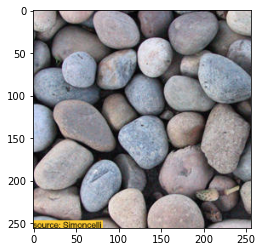

In [3]:
# Take a look
texture = Image.open(BytesIO(urlopen(IMG).read()))
plt.imshow(texture);

In [4]:
# Save it (uncomment to save)
# texture.save("pebbles.jpg")

## Using LBFGS

In [5]:
def generate_texture(
    image,
    img_size=None,
    n_iters=1000,
    layers=None,
    layers_weigths=None,
    log_every=200,
    seed=0,
):

    layers = layers or ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
    layers_weigths = layers_weigths or [1e9] * len(layers)
    
    assert len(layers) == len(layers_weigths)
    
    # Set device and a seed
    device = set_device()
    set_seed(seed)

    # Init model
    model = vgg19().to(device)

    # Prepare texture data
    target = prep_img(image, img_size).to(device)

    # Init input image
    synth = torch.randn_like(target)
    synth = (synth - synth.min()) / (synth.max() - synth.min())
    # synth = norm(synth)  # Not sure about this line
    synth.requires_grad_(True)

    # Set optimizer
    optimizer = optim.LBFGS(
        [synth],
        tolerance_grad=0.0,
        tolerance_change=0.0,
        line_search_fn="strong_wolfe",
    )

    # Get feature maps for the target texture
    target_activations = [*model(target, layers)]

    iter_ = 0
    while iter_ <= n_iters:
        
        def closure():
            nonlocal iter_

    #         # Boundaries?
    #         with torch.no_grad():
    #             synth.clamp_(target.min(), target.max())

            optimizer.zero_grad()

            synth_activations = [*model(synth, layers)]

            assert len(synth_activations) == len(target_activations) == len(layers_weigths)

            losses = []
            for activations in zip(synth_activations, target_activations, layers_weigths):
                losses.append(gram_loss(*activations).unsqueeze(0))

            total_loss = torch.cat(losses).sum()
            total_loss.backward()

            if iter_ == 0 or iter_ % log_every == 0:
                print(iter_, total_loss.item())
                plt.imshow(to_pil(synth.squeeze(0)))
                plt.show()

            iter_ += 1

            return total_loss

        optimizer.step(closure)
    
    # Save generated texture
    to_pil(synth.squeeze()).save("pebbles_gen.png")

0 227352480.0


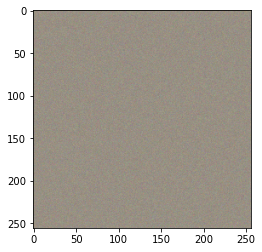

200 404989.4375


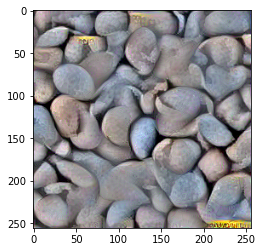

400 190372.53125


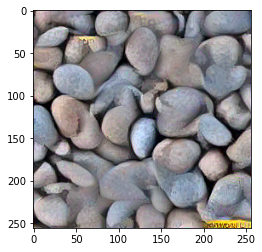

600 139737.4375


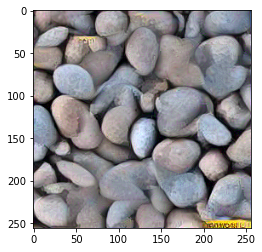

800 119647.875


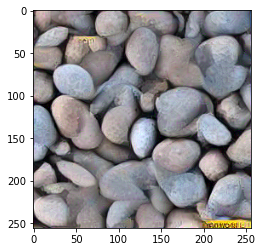

1000 109394.125


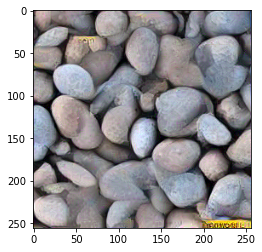

In [6]:
img = "pebbles.jpg"

generate_texture(img, 256)

## Using Adam

In [7]:
def generate_texture(
    image,
    img_size=None,
    n_iters=2000,
    layers=None,
    layers_weigths=None,
    log_every=500,
    seed=0,
):

    layers = layers or ["conv1_1", "pool1", "pool2", "pool3", "pool4"]
    layers_weigths = layers_weigths or [1e9] * len(layers)
    
    assert len(layers) == len(layers_weigths)
    
    # Set device and a seed
    device = set_device()
    set_seed(seed)

    # Init model
    model = vgg19().to(device)

    # Prepare texture data
    target = prep_img(image, img_size).to(device)

    # Init input image
    synth = torch.randn_like(target)
    synth = (synth - synth.min()) / (synth.max() - synth.min())
#     synth = norm(synth)  # Not sure about this line
    synth.requires_grad_(True)

    # Set optimizer
    optimizer = optim.Adam([synth], lr=0.1)

    # Get feature maps for the target texture
    target_activations = [*model(target, layers)]
    
    for iter_ in range(1, n_iters + 1):
        optimizer.zero_grad()

        synth_activations = [*model(synth, layers)]

        assert len(synth_activations) == len(target_activations) == len(layers_weigths)

        losses = []
        for activations in zip(synth_activations, target_activations, layers_weigths):
            losses.append(gram_loss(*activations).unsqueeze(0))

        total_loss = torch.cat(losses).sum()
        total_loss.backward()

        if iter_ == 1 or iter_ % log_every == 0:
            print(iter_, total_loss.item())
            plt.imshow(to_pil(synth.squeeze(0)))
            plt.show()

        optimizer.step()
    
    to_pil(synth.squeeze()).save("pebbles_gen_adam.png")

1 227352480.0


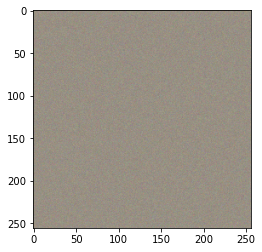

500 423767.125


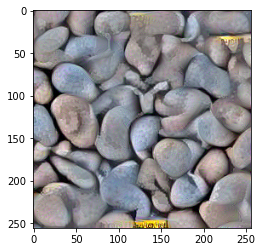

1000 206218.8125


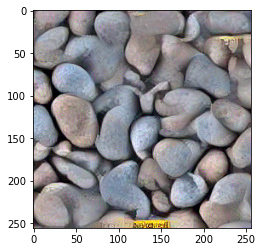

1500 167089.640625


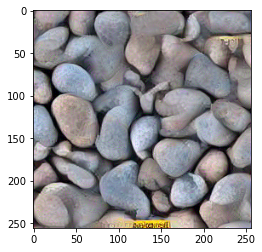

2000 188968.90625


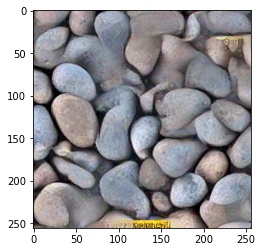

In [8]:
img = "pebbles.jpg"

generate_texture(img, 256)